In [ ]:
''' Compute Integrated Ice Edge Error 
MetUM output vs OSTIA/AMSR2 sea ice analysis'''

'''
TRACKING

DEVELOPMENT done
1. Open a single AMSR2 day file to prepare the regridder
and land mask and testing.
2. Open forecasts from MetUM coupled model, both 025 and 12 
resolution to prepare regridder and testing.
3. Prepare code to isolate sea ice fields, binarise, find
overestimate (O) and underestimate (U).
4. Improve code to calculate O and U for each day of forecast,
saving these data to arrays.
5. Write further code to complete processing as per Helge's
advice, to find Integrated Ice Edge Error (IIEE), Absolute
Extent Error (AEE) and Misplacement Error (ME).
6. Analyse results, produce visualisations. 

NOTES
From Goessling et al. (2016) 'Predictability of the Arctic sea ice edge':
O = sum of grid cell areas of grid cells where (sic_forecast >= 15%) AND (sic_observed < 15%)
U = sum of grid cell areas of grid cells where (sic_forecast < 15%) AND (sic_observed >= 15%)
IIEE = O + U
AEE = absolute value of (O minus U)
ME = IIEE - AEE (= 2 * min (absolute value of O, absolute value of U))

'''

user = 'XXXXXXXX'

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import numpy.ma as ma
import xarray as xr
import xesmf as xe
import pyresample
import pandas as pd
import glob
import fnmatch
import regionmask
from area import area

/local/scratch/jbj13rpu@uea.ac.uk/anaconda3/envs/IGP_env/lib/python3.8/site-packages/pyresample/bilinear/__init__.py:50: UserWarning: XArray and/or zarr not found, XArrayBilinearResampler won't be available.
  warnings.warn("XArray and/or zarr not found, XArrayBilinearResampler won't be available.")


In [44]:
def polar_xy_to_lonlat(x, y, true_scale_lat, re, e, hemisphere, lon_0):
    """Convert from Polar Stereographic (x, y) coordinates to
    geodetic longitude and latitude.
    Args:
        x (float): X coordinate(s) in km
        y (float): Y coordinate(s) in km
        true_scale_lat (float): true-scale latitude in degrees
        hemisphere (1 or -1): 1 for Northern hemisphere, -1 for Southern
        re (float): Earth radius in km
        e (float): Earth eccentricity
    Returns:
        If x and y are scalars then the result is a
        two-element list containing [longitude, latitude].
        If x and y are numpy arrays then the result will be a two-element
        list where the first element is a numpy array containing
        the longitudes and the second element is a numpy array containing
        the latitudes.
    """

    e2 = e * e
    slat = true_scale_lat * np.pi / 180
    rho = np.sqrt(x ** 2 + y ** 2)

    if abs(true_scale_lat - 90.) < 1e-5:
        t = rho * np.sqrt((1 + e) ** (1 + e) * (1 - e) ** (1 - e)) / (2 * re)
    else:
        cm = np.cos(slat) / np.sqrt(1 - e2 * (np.sin(slat) ** 2))
        t = np.tan((np.pi / 4) - (slat / 2)) / \
            ((1 - e * np.sin(slat)) / (1 + e * np.sin(slat))) ** (e / 2)
        t = rho * t / (re * cm)

    chi = (np.pi / 2) - 2 * np.arctan(t)
    lat = chi + \
        ((e2 / 2) + (5 * e2 ** 2 / 24) + (e2 ** 3 / 12)) * np.sin(2 * chi) + \
        ((7 * e2 ** 2 / 48) + (29 * e2 ** 3 / 240)) * np.sin(4 * chi) + \
        (7 * e2 ** 3 / 120) * np.sin(6 * chi)
    lat = hemisphere * lat * 180 / np.pi
    lon = np.arctan2(hemisphere * x, -hemisphere * y)
    lon = hemisphere * lon * 180 / np.pi
    lon = lon + lon_0
    lon = lon + np.less(lon, 0) * 360
    return [lon, lat]


def find_amsr2(date,indir):
    '''Find AMSR2 file by date. For .nc files only.
    Args:
        date (string): 'YYYYMMDD'
        indir (string): local path to directory conntaining AMSR2 files
    '''
    if indir == None:
        indir = '/local/jbj13rpu/Datasets/amsr2/'
    f_list_all = []
    for f in glob.iglob(indir + '**', recursive=True):
        f_list_all.append(f)
    result = []

    pattern = '*' + date + '*' + '.nc'

    for f in f_list_all:
        if fnmatch.fnmatch(f,pattern):
            result.append(f)
    if len(result) != 1:
        print('Warning, more than one AMSR2 file found!')
    result = result[0]
    return result

def find_fc(fc_date,stash,cop_or_uncop,orca_res):
    # orca_res can be 025 or 12
    fc_dir = '/local/jbj13rpu/COP_ORCA_comp/'
    f_list_all = []
    for f in glob.iglob(fc_dir+'**', recursive=True):
        f_list_all.append(f)
    result = []
    streams = ['pa','pb','pd','pg','ph']
    for stream in streams:
        if cop_or_uncop == 'cop':
            pattern = '*'+orca_res+'*'+fc_date+'*'+stream+'*'+stash+'*'+'.nc'
        elif cop_or_uncop == 'uncop':
            pattern = '*'+fc_date+'*'+'calc'+'*'+stash+'*'+'.nc'
        else:
            print('No files found, check search terms.')
        for f in f_list_all:
            if fnmatch.fnmatch(f,pattern):
                result.append(f)
    return result[0]

def find_fc_mod(fc_date,stash,cop_or_uncop,orca_res):
    # orca_res can be 025 or 12
    fc_dir = '/local/jbj13rpu/reduced_drag_u-cd647/'
    f_list_all = []
    for f in glob.iglob(fc_dir+'**', recursive=True):
        f_list_all.append(f)
    result = []
    streams = ['pa','pb','pd','pg','ph']
    for stream in streams:
        if cop_or_uncop == 'cop':
            pattern = '*'+orca_res+'*'+fc_date+'*'+stream+'*'+stash+'*'+'.nc'
        elif cop_or_uncop == 'uncop':
            pattern = '*'+fc_date+'*'+'calc'+'*'+stash+'*'+'.nc'
        else:
            print('No files found, check search terms.')
        for f in f_list_all:
            if fnmatch.fnmatch(f,pattern):
                result.append(f)
    return result[0]

In [3]:
'''
Find Von Neumann neighbourhood
matrix is a N-dimensional matrix
coordinates of the cell is a N-length tuple
distance is the reach of the neighbourhood
from: https://codereview.stackexchange.com/questions/199754/codewars-n-dimensional-von-neumann-neighborhood-in-a-matrix
'''

def get_neighbourhood(matrix, coordinates, distance=1):
    dimensions = len(coordinates)
    neigh = []
    app = neigh.append

    def recc_von_neumann(arr, curr_dim=0, remaining_distance=distance, isCenter=True):
        #the breaking statement of the recursion
        if curr_dim == dimensions:
            if not isCenter:
                app(arr)
            return

        dimensions_coordinate = coordinates[curr_dim]
        if not (0 <= dimensions_coordinate < len(arr)):
            return 

        dimension_span = range(dimensions_coordinate - remaining_distance, 
                              dimensions_coordinate + remaining_distance + 1)
        for c in dimension_span:
            if 0 <= c < len(arr):
                recc_von_neumann(arr[c], 
                                 curr_dim + 1, 
                                 remaining_distance - abs(dimensions_coordinate - c), 
                                 isCenter and dimensions_coordinate == c)
        return
    
    recc_von_neumann(matrix)
    return neigh

In [5]:
### manually prepare regidding here, however needs
### updating to make use of pre-regridded data

In [6]:
# open an individual AMSR2 file to set original curvilinear grid
date = '20180304'
indir = '/local/{}/Datasets/amsr2/'.format(user)
ds = xr.open_dataset(find_amsr2(date,indir))

### calculate 2D lat/lon arrays from from curvilinear y/x grid
# TO DO - turn this into reusable function

x = ds.x
y = ds.y

# set parameters for projection
true_scale_lat = 70
re = 6378237 / 1000 #m to km
# e = math.sqrt(6.69437999014*10**-3)
e = 0.081816153
hemisphere = 1 # North = 1
lon_0 = -45

# must convert x/y from m to km
xc,yc = polar_xy_to_lonlat(x/1000, y/1000, 
                           true_scale_lat, re,
                           e, hemisphere, lon_0)

# add lat/lon to ds
ds = ds.assign_coords({'lon': xc, 'lat': yc})

### set output grid
# resolution in degrees
res = 0.06 # ~6 km
ds_out = xe.util.grid_global(res,res)

### set regridder (time intensive step, may kill kernel at high res, reuse file where poss)
regridder_amsr2 = xe.Regridder(ds, ds_out, 'bilinear',
                        reuse_weights='True')

# select sea ice conc var and regrid to new dataarray
da = ds['z']
da = da.transpose()
da_out = regridder_amsr2(da)

### Now cut down AMSR2 to study region
lon_1d = da_out.lon[0,:].data
lat_1d = da_out.lat[:,0].data
sic = da_out.data

da_amsr2 = xr.DataArray(sic,coords={'lat':lat_1d,'lon':lon_1d},
                        dims=['lat','lon'])

da_amsr2_cut = da_amsr2.where(da_amsr2.lat>68,drop=True)
da_amsr2_cut = da_amsr2_cut.where(da_amsr2.lat<75,drop=True)
da_amsr2_cut = da_amsr2_cut.where(da_amsr2.lon>-35,drop=True)
da_amsr2_cut = da_amsr2_cut.where(da_amsr2.lon<-5,drop=True)

Reuse existing file: bilinear_1216x1792_3000x6000.nc


In [7]:
# create land mask for amsr2 land
# create array with 2=land
mask_land_amsr2 = 2 * np.ones((len(da_amsr2_cut['lat']),
                            len(da_amsr2_cut['lon']))) \
                    * np.isnan(da_amsr2_cut)

# adjust amsr2 land mask to increase distance from coast
# using von neumann neighbourhood method
'''set radius of grid cells to adjust.
currently have regridder set to 0.06 deg so roughly 6km/cell.
iterate over each grid cell, if land - find neighbours, 
change to land if not.
DECIDE -> can add longitude cut off for Jan Mayen?
'''
radius = 5
orig_arr = mask_land_amsr2
out_arr = mask_land_amsr2.copy()

for i in range(orig_arr.shape[0]):
    for j in range(orig_arr.shape[1]):
        
        if orig_arr[i,j] == 2:
            neigh_list = get_neighbourhood(mask_land_amsr2,
                         (i,j),
                         distance=radius)
        
            for k in neigh_list:
#                 if k.lon < -12.0: ## for Jan Mayen ## include this to exclude Jan Mayen from land mask adjustment
                if k == 0:
                    out_arr.loc[dict(lon=k.lon,lat=k.lat)] = 2

In [8]:
# extra fill in of scoresby sund fjord
land_mask_rad_5 = out_arr.copy()
land_mask_rad_5.loc[dict(lat=slice(70,72),
                        lon=slice(-28,-24))] = 2.0

<ipython-input-45-c28c06dae313>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(da_amsr2_cut.lon,


Text(0.5, 1.0, 'AMSR2 sea ice conc.')

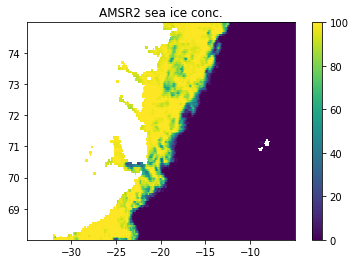

In [45]:
fig = plt.figure(figsize=(6,4))
plt.pcolormesh(da_amsr2_cut.lon,
              da_amsr2_cut.lat,
              da_amsr2_cut)
plt.colorbar()
plt.title('AMSR2 sea ice conc.')

Text(0.5, 1.0, 'Land Mask +~30km')

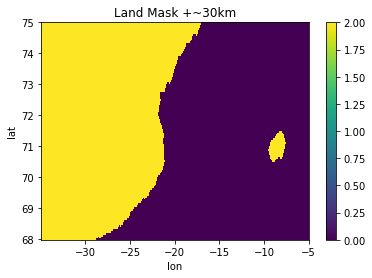

In [10]:
fig = plt.figure(figsize=(6,4))
land_mask_rad_5.plot()
plt.title('Land Mask +~30km')

Text(0.5, 1.0, 'AMSR2 (MASKED)')

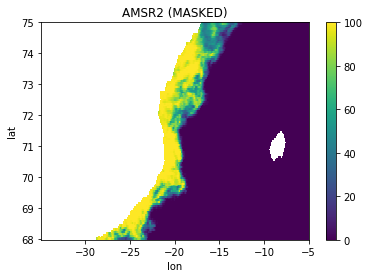

In [12]:
da_amsr2_cut.coords['land_mask'] = (('lat','lon'), land_mask_rad_5)
da_amsr2_cut.where(da_amsr2_cut.land_mask!=2).plot()
plt.title('AMSR2 (MASKED)')

In [13]:
### automated for later, note does not include prep of regridder yet
def prep_amsr2_data_for_day(date):
    '''date in format 'YYYYMMDD' '''
    # open an AMSR2 file to set original curvilinear grid
    indir = '/local/{}/Datasets/amsr2/'.format(user)
    ds = xr.open_dataset(find_amsr2(date,indir))

    ### calculate 2D lat/lon arrays from from curvilinear y/x grid
    # TO DO - turn this into reusable function
    x = ds.x
    y = ds.y

    # set parameters for projection
    true_scale_lat = 70
    re = 6378237 / 1000 #m to km
    e = 0.081816153
    hemisphere = 1 # North = 1
    lon_0 = -45
    # must convert x/y from m to km
    xc,yc = polar_xy_to_lonlat(x/1000, y/1000, 
                               true_scale_lat, re,
                               e, hemisphere, lon_0)
    # add lat/lon to ds
    ds = ds.assign_coords({'lon': xc, 'lat': yc})
    
    # select sea ice conc var and regrid to new dataarray
    da = ds['z']
    da = da.transpose()
    da_out = regridder_amsr2(da)
    
    ### Now cut down AMSR2 to study region
    lon_1d = da_out.lon[0,:].data
    lat_1d = da_out.lat[:,0].data
    sic = da_out.data
    da_amsr2 = xr.DataArray(sic,coords={'lat':lat_1d,'lon':lon_1d},
                            dims=['lat','lon'])
    da_amsr2_cut = da_amsr2.where(da_amsr2.lat>68,drop=True)
    da_amsr2_cut = da_amsr2_cut.where(da_amsr2.lat<75,drop=True)
    da_amsr2_cut = da_amsr2_cut.where(da_amsr2.lon>-35,drop=True)
    da_amsr2_cut = da_amsr2_cut.where(da_amsr2.lon<-5,drop=True)
    
    da_amsr2_cut.coords['land_mask'] = (('lat','lon'), land_mask_rad_5)
    
    return da_amsr2_cut

In [14]:
def prep_ostia_data_for_day(date_np64):
    f = '/local/{}/Datasets/METOFFICE-GLO-SST-L4-REP-OBS-SST_1586302141505.nc'.format(user)
    ds_ostia = xr.open_dataset(f)
    regridder_ostia = xe.Regridder(ds_ostia,da_amsr2_cut,'bilinear',
                            reuse_weights='True')
    ds_ostia_regrid = regridder_ostia(ds_ostia)

    ds_ostia_cut = ds_ostia_regrid.sel(time=date_np64)
    da_ostia_cut = ds_ostia_cut['sea_ice_fraction']
    da_ostia_cut.coords['land_mask'] = (('lat','lon'), land_mask_rad_5)
    
    return da_ostia_cut

Reuse existing file: bilinear_601x1400_117x500.nc
using dimensions ('lat', 'lon') from data variable analysis_error as the horizontal dimensions for this dataset.


Text(0.5, 1.0, 'OSTIA')

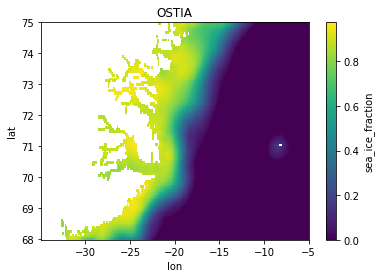

In [15]:
date_np64 = np.datetime64('2018-03-04T12:00:00')
da_ostia = prep_ostia_data_for_day(date_np64)
da_ostia.plot()
plt.title('OSTIA')

Reuse existing file: bilinear_601x1400_117x500.nc
using dimensions ('lat', 'lon') from data variable analysis_error as the horizontal dimensions for this dataset.


Text(0.5, 1.0, 'OSTIA (MASKED)')

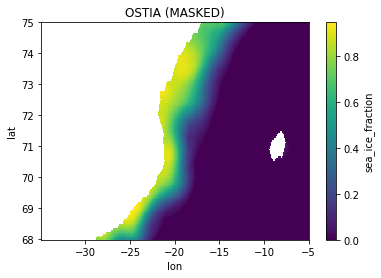

In [16]:
da_ostia = prep_ostia_data_for_day(date_np64)
da_ostia.where(da_ostia.land_mask!=2).plot()
plt.title('OSTIA (MASKED)')

In [17]:
### Next, open MetUM coupled model output, 
### regrid and cut to match AMSR2 

fc_date = '20180301'
stash = '00031'
cop_or_uncop = 'cop'
res_025 = '025'
res_12 = '12'

# 1/4 deg
f = find_fc(fc_date,stash,cop_or_uncop,res_025)
ds_cop_025 = xr.open_dataset(f)
ds_cop_025 = ds_cop_025.where(ds_cop_025.longitude>=320,drop=True)
ds_cop_025 = ds_cop_025.rename({'longitude':'lon',
                                'latitude':'lat'})
ds_cop_025 = ds_cop_025.drop(['forecast_period','forecast_reference_time',
                'latitude_longitude'])

# 1/4 deg mod REDUCED DRAG
f = find_fc_mod(fc_date,stash,cop_or_uncop,res_025)
ds_cop_025_mod = xr.open_dataset(f)
ds_cop_025_mod = ds_cop_025_mod.where(ds_cop_025_mod.longitude>=320,drop=True)
ds_cop_025_mod = ds_cop_025_mod.rename({'longitude':'lon',
                                'latitude':'lat'})
ds_cop_025_mod = ds_cop_025_mod.drop(['forecast_period','forecast_reference_time',
                'latitude_longitude'])

# 1/12 deg
f = find_fc(fc_date,stash,cop_or_uncop,res_12)
ds_cop_12 = xr.open_dataset(f)
ds_cop_12 = ds_cop_12.where(ds_cop_12.longitude>=320,drop=True)
ds_cop_12 = ds_cop_12.rename({'longitude':'lon',
                                'latitude':'lat'})
ds_cop_12 = ds_cop_12.drop(['forecast_period','forecast_reference_time',
                'latitude_longitude'])

In [18]:
# for later:
def prep_fc_data(ds):
    ds = xr.open_dataset(f)
    ds = ds.where(ds.longitude>=320,drop=True)
    ds = ds.rename({'longitude':'lon',
                                    'latitude':'lat'})
    ds = ds.drop(['forecast_period','forecast_reference_time',
                    'latitude_longitude'])
    return ds

In [19]:
regridder_um025 = xe.Regridder(ds_cop_025,da_amsr2_cut,'bilinear',
                        reuse_weights='True')
regridder_um12 = xe.Regridder(ds_cop_12,da_amsr2_cut,'bilinear',
                        reuse_weights='True')

ds_cop_025_regrid = regridder_um025(ds_cop_025)
ds_cop_025_mod_regrid = regridder_um025(ds_cop_025_mod)
ds_cop_12_regrid = regridder_um12(ds_cop_12)

ds_cop_025_regrid.coords['land_mask'] = (('lat','lon'), land_mask_rad_5)
ds_cop_025_mod_regrid.coords['land_mask'] = (('lat','lon'), land_mask_rad_5)
ds_cop_12_regrid.coords['land_mask'] = (('lat','lon'), land_mask_rad_5)

Reuse existing file: bilinear_320x284_117x500.nc
Reuse existing file: bilinear_320x284_117x500.nc
using dimensions ('lat', 'lon') from data variable sea_ice_area_fraction as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable sea_ice_area_fraction as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable sea_ice_area_fraction as the horizontal dimensions for this dataset.


/local/scratch/jbj13rpu@uea.ac.uk/anaconda3/envs/IGP_env/lib/python3.8/site-packages/xesmf/smm.py:70: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


<ipython-input-46-28140735b159>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ds_cop_025_regrid.lon,
<ipython-input-46-28140735b159>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ds_cop_025_regrid.lon,


Text(0.5, 1.0, 'Coupled 1/4 deg (MASKED)')

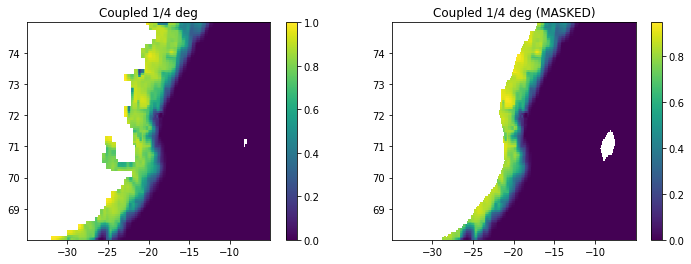

In [46]:
fig = plt.figure(figsize=(12,4))
ax0 = plt.subplot(121)
plt.pcolormesh(ds_cop_025_regrid.lon,
              ds_cop_025_regrid.lat,
              ds_cop_025_regrid.sea_ice_area_fraction.isel(time=1))
plt.colorbar()
plt.title('Coupled 1/4 deg')

ax1 = plt.subplot(122)
plt.pcolormesh(ds_cop_025_regrid.lon,
              ds_cop_025_regrid.lat,
              ds_cop_025_regrid.sea_ice_area_fraction.isel(time=1).where(
              ds_cop_025_regrid.land_mask!=2))
plt.colorbar()
plt.title('Coupled 1/4 deg (MASKED)')

<ipython-input-21-d895e1bd1335>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ds_cop_12_regrid.lon,
<ipython-input-21-d895e1bd1335>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ds_cop_12_regrid.lon,


Text(0.5, 1.0, 'Coupled 1/12 deg (MASKED)')

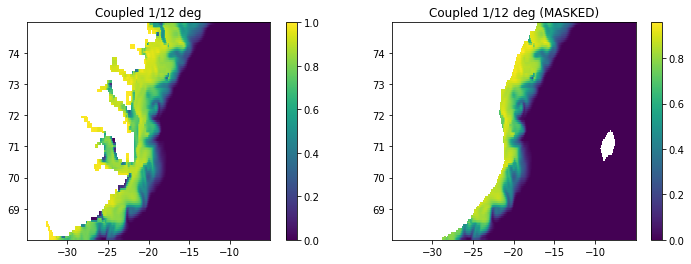

In [21]:
fig = plt.figure(figsize=(12,4))
ax0 = plt.subplot(121)
plt.pcolormesh(ds_cop_12_regrid.lon,
              ds_cop_12_regrid.lat,
              ds_cop_12_regrid.sea_ice_area_fraction.isel(time=1))
plt.colorbar()
plt.title('Coupled 1/12 deg')

ax1 = plt.subplot(122)
plt.pcolormesh(ds_cop_12_regrid.lon,
              ds_cop_12_regrid.lat,
              ds_cop_12_regrid.sea_ice_area_fraction.isel(time=1).where(
              ds_cop_12_regrid.land_mask!=2))
plt.colorbar()
plt.title('Coupled 1/12 deg (MASKED)')

In [22]:
### Now need to 'binarise' sea ice
# create array where any grid cell with SIC > 0% == 1

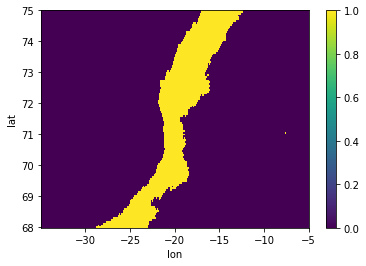

In [23]:
da_amsr2_bi = da_amsr2_cut.where(da_amsr2_cut.land_mask!=2)
da_amsr2_bi = da_amsr2_bi > 0.15
da_amsr2_bi = da_amsr2_bi.astype(int)
da_amsr2_bi.plot()

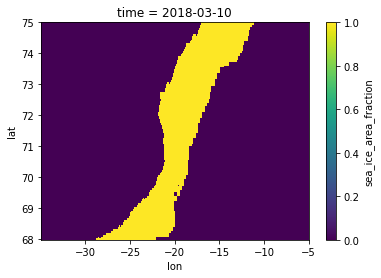

In [24]:
da_025_bi = ds_cop_025_regrid.sea_ice_area_fraction.isel(time=9)
da_025_bi = da_025_bi.where(da_025_bi.land_mask!=2)
da_025_bi = da_025_bi > 0
da_025_bi = da_025_bi.astype(int)
da_025_bi.plot()

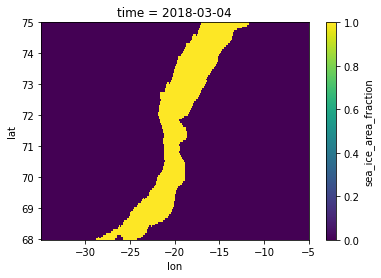

In [25]:
da_12_bi = ds_cop_12_regrid.sea_ice_area_fraction.isel(time=3)
da_12_bi = da_12_bi.where(da_12_bi.land_mask!=2)
da_12_bi = da_12_bi > 0.15
da_12_bi = da_12_bi.astype(int)
da_12_bi.plot()

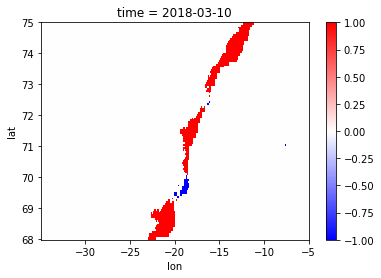

In [26]:
diff2 = da_025_bi - da_amsr2_bi 
diff2.plot(cmap='bwr')

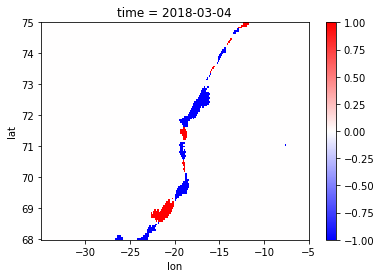

In [27]:
diff3 = da_12_bi - da_amsr2_bi 
diff3.plot(cmap='bwr')

<ipython-input-28-1369308719ad>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ds_cop_12_regrid.lon,
<ipython-input-28-1369308719ad>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(da_amsr2_cut.lon,
<ipython-input-28-1369308719ad>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading=

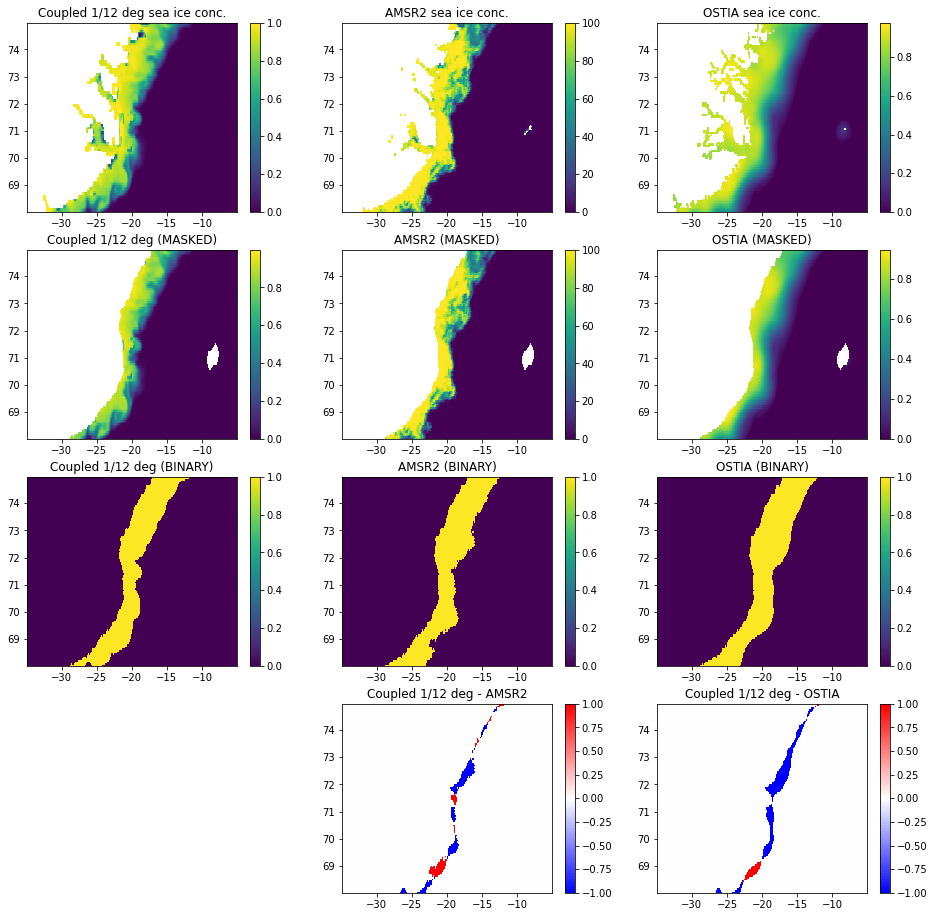

In [28]:
# check all steps functioning correctly
fig = plt.figure(figsize=(16,16))

ax1 = plt.subplot(431)
plt.pcolormesh(ds_cop_12_regrid.lon,
              ds_cop_12_regrid.lat,
              ds_cop_12_regrid.sea_ice_area_fraction.isel(time=3))
plt.colorbar()
plt.title('Coupled 1/12 deg sea ice conc.')

ax2 = plt.subplot(432)
plt.pcolormesh(da_amsr2_cut.lon,
              da_amsr2_cut.lat,
              da_amsr2_cut)
plt.colorbar()
plt.title('AMSR2 sea ice conc.')

ax3 = plt.subplot(433)
plt.pcolormesh(da_ostia.lon,
              da_ostia.lat,
              da_ostia)
plt.colorbar()
plt.title('OSTIA sea ice conc.')

ax4 = plt.subplot(434)
plt.pcolormesh(ds_cop_12_regrid.lon,
              ds_cop_12_regrid.lat,
              ds_cop_12_regrid.sea_ice_area_fraction.isel(time=3).where(
              ds_cop_12_regrid.land_mask!=2))
plt.colorbar()
plt.title('Coupled 1/12 deg (MASKED)')

ax5 = plt.subplot(435)
plt.pcolormesh(da_amsr2_cut.lon,
              da_amsr2_cut.lat,
              da_amsr2_cut.where(da_amsr2_cut.land_mask!=2))
plt.colorbar()
plt.title('AMSR2 (MASKED)')

ax6 = plt.subplot(436)
plt.pcolormesh(da_ostia.lon,
              da_ostia.lat,
              da_ostia.where(da_ostia.land_mask!=2))
plt.colorbar()
plt.title('OSTIA (MASKED)')

ax7 = plt.subplot(437)
da_12_bi = ds_cop_12_regrid.sea_ice_area_fraction.isel(time=3)
da_12_bi = da_12_bi.where(da_12_bi.land_mask!=2)
da_12_bi = da_12_bi >= 0.15
da_12_bi = da_12_bi.astype(int)
plt.pcolormesh(da_12_bi.lon,
              da_12_bi.lat,
              da_12_bi)
plt.colorbar()
plt.title('Coupled 1/12 deg (BINARY)')

ax8 = plt.subplot(438)
da_amsr2_bi = da_amsr2_cut.where(da_amsr2_cut.land_mask!=2)
da_amsr2_bi = da_amsr2_bi > 0.15
da_amsr2_bi = da_amsr2_bi.astype(int)
plt.pcolormesh(da_amsr2_bi.lon,
              da_amsr2_bi.lat,
              da_amsr2_bi)
plt.colorbar()
plt.title('AMSR2 (BINARY)')

ax9 = plt.subplot(439)
da_ostia_bi = da_ostia.where(da_ostia.land_mask!=2)
da_ostia_bi = da_ostia_bi > 0.15
da_ostia_bi = da_ostia_bi.astype(int)
plt.pcolormesh(da_ostia.lon,
              da_ostia.lat,
               da_ostia_bi)
plt.colorbar()
plt.title('OSTIA (BINARY)')

ax11 = plt.subplot(4,3,11)
diff_amsr2 = da_12_bi - da_amsr2_bi 
plt.pcolormesh(diff_amsr2.lon,
              diff_amsr2.lat,
               diff_amsr2,
              cmap='bwr')
plt.colorbar()
plt.title('Coupled 1/12 deg - AMSR2')

ax12 = plt.subplot(4,3,12)
diff_ostia = da_12_bi - da_ostia_bi 
plt.pcolormesh(diff_ostia.lon,
              diff_ostia.lat,
               diff_ostia,
              cmap='bwr')
plt.colorbar()
plt.title('Coupled 1/12 deg - OSTIA')

fig.savefig('./IIEE_method_example.jpg',dpi=300)

In [38]:
### use 'area' function --> works well
### try 'area' library that uses GeoJSON-area 
### see https://github.com/scisco/area/blob/master/README.rst

re = 6378237 / 1000
lat1 = da_amsr2_bi.lat[-1]
lat2 = da_amsr2_bi.lat[-2]
lon1 = da_amsr2_bi.lon[-1]
lon2 = da_amsr2_bi.lon[-2]

cell = {'type':'Polygon',
        'coordinates': [[[lon1,lat1],
                         [lon1,lat2],
                         [lon2,lat2],
                         [lon2,lat1],
                         [lon1,lat1]]]}

cell_area = area(cell)/1000/1000
print(cell_area.data)

### Double check it is accurate manually

# (np.pi/180)*(re**2)* \

# (abs(np.sin(np.deg2rad(lat1)) \
#      -np.sin(np.deg2rad(lat2)))) \
# *(abs((lon1)-(lon2)))

11.591373375967347


In [30]:
def calc_O_and_U_area(arr):
    
    grid_size = 0.06
    grid_cell_offset = grid_size/2
    O_area = 0
    U_area = 0

    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):

            if arr[i,j] == 1:
                lon_mid = arr[i,j].lon
                lat_mid = arr[i,j].lat
                lon1 = lon_mid - grid_cell_offset
                lon2 = lon_mid + grid_cell_offset
                lat1 = lat_mid - grid_cell_offset
                lat2 = lat_mid + grid_cell_offset

                cell = {'type':'Polygon',
                    'coordinates': [[[lon1,lat1],
                                     [lon1,lat2],
                                     [lon2,lat2],
                                     [lon2,lat1],
                                     [lon1,lat1]]]}

                cell_area = area(cell)/(1*10**6)
                O_area = O_area + cell_area

            elif arr[i,j] == -1:
                lon_mid = arr[i,j].lon
                lat_mid = arr[i,j].lat
                lon1 = lon_mid - grid_cell_offset
                lon2 = lon_mid + grid_cell_offset
                lat1 = lat_mid - grid_cell_offset
                lat2 = lat_mid + grid_cell_offset

                cell = {'type':'Polygon',
                    'coordinates': [[[lon1,lat1],
                                     [lon1,lat2],
                                     [lon2,lat2],
                                     [lon2,lat1],
                                     [lon1,lat1]]]}

                cell_area = area(cell)/(1*10**6)
                U_area = U_area + cell_area
                
    if O_area > 0:
        O_area = O_area.data
    if U_area > 0:
        U_area = U_area.data
        
    return O_area,U_area

In [31]:
####### END OF DEV #######

In [33]:
### large script to do three forecasts for AMSR2 and OSTIA 
### NEEDS OPTIMISING currently written verbosely for development 
### but should be looped
# requires that forecast data has already been processed and 
# saved to netcdf on Monsoon then downloaded to local

In [73]:
### Process for results
# for three forecasts (20180217,20180301.20180401)

fc_list = ['20180217'] #,'20180301','20180401']

# set SIC threshold (min_sic in % ; if all sea ice use 0.01)
min_sic = 15
min_sic_fc = min_sic/100

diff_025_P_amsr2_list = []
diff_025_amsr2_list = []
diff_025_mod_amsr2_list = []
diff_12_amsr2_list = []

diff_025_P_ostia_list = []
diff_025_ostia_list = []
diff_025_mod_ostia_list = []
diff_12_ostia_list = []

for fc in fc_list:
    
    ### open forecast
    fc_date = fc
    stash = '00031'
    cop_or_uncop = 'cop'
    res_025 = '025'
    res_12 = '12'

    # 1/4 deg
    f = find_fc(fc_date,stash,cop_or_uncop,res_025)
    ds_025 = xr.open_dataset(f)
    ds_025 = prep_fc_data(ds_025)
    
    # 1/4 deg mod reduced drag
    f = find_fc_mod(fc_date,stash,cop_or_uncop,res_025)
    ds_025_mod = xr.open_dataset(f)
    ds_025_mod = prep_fc_data(ds_025_mod)

    # 1/12 deg
    f = find_fc(fc_date,stash,cop_or_uncop,res_12)
    ds_12 = xr.open_dataset(f)
    ds_12 = prep_fc_data(ds_12)

    fc_time_range = ds_025.time

    # using earlier prepped regridder
    ds_025 = regridder_um025(ds_025)
    ds_025_mod = regridder_um025(ds_025_mod)
    ds_12 = regridder_um12(ds_12)

    ds_025.coords['land_mask'] = (('lat','lon'), land_mask_rad_5)
    ds_025_mod.coords['land_mask'] = (('lat','lon'), land_mask_rad_5)
    ds_12.coords['land_mask'] = (('lat','lon'), land_mask_rad_5)

    fc_prods = [ds_025,ds_025_mod,ds_12]
    
    ##### calculate IIEE
    
    # prep lists for data collection
    time_list = []
    
    ### AMSR2
    O_025_P_amsr2_list = []
    U_025_P_amsr2_list = []
    O_025_amsr2_list = []
    U_025_amsr2_list = []
    O_025_mod_amsr2_list = []
    U_025_mod_amsr2_list = []
    O_12_amsr2_list = []
    U_12_amsr2_list = []   
    
    ### OSTIA
    O_025_P_ostia_list = []
    U_025_P_ostia_list = []
    O_025_ostia_list = []
    U_025_ostia_list = []
    O_025_mod_ostia_list = []
    U_025_mod_ostia_list = []
    O_12_ostia_list = []
    U_12_ostia_list = []
    
    # calculate over and under estimations for each forecast timestep
    for time in fc_time_range:

        ini_time = np.datetime64(fc_time_range[0].data.astype('<M8[s]'))
        timestamp = pd.to_datetime(time.data)
        date = timestamp.strftime("%Y%m%d")   
        year = date[0:4]
        month = date[4:6]
        day = date[6:8]
        time_str = year+'-'+month+'-'+day+'T00:00:00'
        time_str_ostia = year+'-'+month+'-'+day+'T12:00:00'
        date_np64 = np.datetime64(time_str)
        date_np64_ostia = veri_time = np.datetime64(time_str_ostia)
        
        # sea ice prep
        da_amsr2_cut = prep_amsr2_data_for_day(date)   
        da_amsr2_bi = da_amsr2_cut.where(da_amsr2_cut.land_mask!=2)
        da_amsr2_bi = da_amsr2_bi >= min_sic
        da_amsr2_bi = da_amsr2_bi.astype(int)
        
        da_ostia_cut = prep_ostia_data_for_day(date_np64_ostia)   
        da_ostia_bi = da_ostia_cut.where(da_ostia_cut.land_mask!=2)
        da_ostia_bi = da_ostia_bi >= min_sic_fc
        da_ostia_bi = da_ostia_bi.astype(int)
        da_ostia_bi = da_ostia_bi.drop('time')
        
        sat_prods = [da_amsr2_bi,da_ostia_bi]
        
        def calc_model_diff_to_sat_prod(name,fc_prod,sat_prod,fc,min_sic_fc,ini_time,veri_time,date_np64):
            if name in ['diff_025_P_amsr2','diff_025_P_ostia']:
                model_step = ini_time
            else:
                model_step = date_np64

            da = fc_prod.sea_ice_area_fraction.sel(time=model_step)
            da = da.where(da.land_mask!=2)
            da = da >= min_sic_fc
            da = da.astype(int)
            da = da.drop('time')

            diff = da - sat_prod
            O,U = calc_O_and_U_area(diff)
            diff = diff.assign_coords({'forecast_date': ini_time,
                                       'verification_time': date_np64_ostia})
            diff = diff.expand_dims(['forecast_date','verification_time'])
            diff = diff.rename(name+'_'+fc)

            return diff,O,U
            
        # persistent ice (currently just using 1/4 deg forecast)
        ### AMSR2
        diff_025_P_amsr2,O_025_P_amsr2,U_025_P_amsr2 = calc_model_diff_to_sat_prod('diff_025_P_amsr2',ds_025,da_amsr2_bi,fc,min_sic_fc,ini_time,veri_time,date_np64)
        ### OSTIA
        diff_025_P_ostia,O_025_P_ostia,U_025_P_astia = calc_model_diff_to_sat_prod('diff_025_P_ostia',ds_025,da_ostia_bi,fc,min_sic_fc,ini_time,veri_time,date_np64)
        
        # coupled 1/4 deg forecast
        ### AMSR2
        diff_025_amsr2,O_025_amsr2,U_025_amsr2 = calc_model_diff_to_sat_prod('diff_025_amsr2',ds_025,da_amsr2_bi,fc,min_sic_fc,ini_time,veri_time,date_np64)
        ### OSTIA
        diff_025_ostia,O_025_ostia,U_025_astia = calc_model_diff_to_sat_prod('diff_025_ostia',ds_025,da_ostia_bi,fc,min_sic_fc,ini_time,veri_time,date_np64)
        
        # coupled 1/4 deg forecast MOD REDUCED DRAG
        ### AMSR2
        diff_025_mod_amsr2,O_025_mod_amsr2,U_025_mod_amsr2 = calc_model_diff_to_sat_prod('diff_025_mod_amsr2',ds_025_mod,da_amsr2_bi,fc,min_sic_fc,ini_time,veri_time,date_np64)
        ### OSTIA
        diff_025_mod_ostia,O_025_mod_ostia,U_025_mod_astia = calc_model_diff_to_sat_prod('diff_025_mod_ostia',ds_025_mod,da_ostia_bi,fc,min_sic_fc,ini_time,veri_time,date_np64)
        
        # coupled 1/12 deg forecast
        ### AMSR2
        diff_12_amsr2,O_12_amsr2,U_12_amsr2 = calc_model_diff_to_sat_prod('diff_12_amsr2',ds_12,da_amsr2_bi,fc,min_sic_fc,ini_time,veri_time,date_np64)
        ### OSTIA
        diff_12_ostia,O_12_ostia,U_12_astia = calc_model_diff_to_sat_prod('diff_12_ostia',ds_12,da_ostia_bi,fc,min_sic_fc,ini_time,veri_time,date_np64)

        # save data
        time_list.append(date_np64)
        
        ### AMSR2
        O_025_P_amsr2_list.append(O_025_P_amsr2)
        U_025_P_amsr2_list.append(U_025_P_amsr2)
        diff_025_P_amsr2_list.append(diff_025_P_amsr2)
        O_025_amsr2_list.append(O_025_amsr2)
        U_025_amsr2_list.append(U_025_amsr2)
        diff_025_amsr2_list.append(diff_025_amsr2)
        O_025_mod_amsr2_list.append(O_025_mod_amsr2)
        U_025_mod_amsr2_list.append(U_025_mod_amsr2)
        diff_025_mod_amsr2_list.append(diff_025_mod_amsr2)
        O_12_amsr2_list.append(O_12_amsr2)
        U_12_amsr2_list.append(U_12_amsr2)
        diff_12_amsr2_list.append(diff_12_amsr2)
        
        ### OSTIA
        O_025_P_ostia_list.append(O_025_P_ostia)
        U_025_P_ostia_list.append(U_025_P_ostia)
        diff_025_P_ostia_list.append(diff_025_P_ostia)
        O_025_ostia_list.append(O_025_ostia)
        U_025_ostia_list.append(U_025_ostia)
        diff_025_ostia_list.append(diff_025_ostia)
        O_025_mod_ostia_list.append(O_025_mod_ostia)
        U_025_mod_ostia_list.append(U_025_mod_ostia)
        diff_025_mod_ostia_list.append(diff_025_mod_ostia)
        O_12_ostia_list.append(O_12_ostia)
        U_12_ostia_list.append(U_12_ostia)
        diff_12_ostia_list.append(diff_12_ostia)
    
    # create dataframe
    data = {'time': time_list,
            'O_025_P_amsr2': O_025_P_amsr2_list,
           'U_025_P_amsr2': U_025_P_amsr2_list,
           'O_025_amsr2': O_025_amsr2_list,
           'U_025_amsr2': U_025_amsr2_list,
           'O_025_mod_amsr2': O_025_mod_amsr2_list,
           'U_025_mod_amsr2': U_025_mod_amsr2_list,
           'O_12_amsr2': O_12_amsr2_list,
           'U_12_amsr2': U_12_amsr2_list,
           'O_025_P_ostia': O_025_P_ostia_list,
           'U_025_P_ostia': U_025_P_ostia_list,
           'O_025_ostia': O_025_ostia_list,
           'U_025_ostia': U_025_ostia_list,
           'O_025_mod_ostia': O_025_mod_ostia_list,
           'U_025_mod_ostia': U_025_mod_ostia_list,
           'O_12_ostia': O_12_ostia_list,
           'U_12_ostia': U_12_ostia_list
           }
    
    df = pd.DataFrame(data=data)
    
    # calc IIEE and components
    df['IIEE_025_P_amsr2'] = df['O_025_P_amsr2'] + df['U_025_P_amsr2']
    df['AEE_025_P_amsr2'] = abs(df['O_025_P_amsr2'] - df['U_025_P_amsr2'])
    df['ME_025_P_amsr2'] = df['IIEE_025_P_amsr2'] - df['AEE_025_P_amsr2']
    df['IIEE_025_amsr2'] = df['O_025_amsr2'] + df['U_025_amsr2']
    df['AEE_025_amsr2'] = abs(df['O_025_amsr2'] - df['U_025_amsr2'])
    df['ME_025_amsr2'] = df['IIEE_025_amsr2'] - df['AEE_025_amsr2']
    df['IIEE_025_mod_amsr2'] = df['O_025_mod_amsr2'] + df['U_025_mod_amsr2']
    df['AEE_025_mod_amsr2'] = abs(df['O_025_mod_amsr2'] - df['U_025_mod_amsr2'])
    df['ME_025_mod_amsr2'] = df['IIEE_025_mod_amsr2'] - df['AEE_025_mod_amsr2']
    df['IIEE_12_amsr2'] = df['O_12_amsr2'] + df['U_12_amsr2']
    df['AEE_12_amsr2'] = abs(df['O_12_amsr2'] - df['U_12_amsr2'])
    df['ME_12_amsr2'] = df['IIEE_12_amsr2'] - df['AEE_12_amsr2']
    
    df['IIEE_025_P_ostia'] = df['O_025_P_ostia'] + df['U_025_P_ostia']
    df['AEE_025_P_ostia'] = abs(df['O_025_P_ostia'] - df['U_025_P_ostia'])
    df['ME_025_P_ostia'] = df['IIEE_025_P_ostia'] - df['AEE_025_P_ostia']
    df['IIEE_025_ostia'] = df['O_025_ostia'] + df['U_025_ostia']
    df['AEE_025_ostia'] = abs(df['O_025_ostia'] - df['U_025_ostia'])
    df['ME_025_ostia'] = df['IIEE_025_ostia'] - df['AEE_025_ostia']
    df['IIEE_025_mod_ostia'] = df['O_025_mod_ostia'] + df['U_025_mod_ostia']
    df['AEE_025_mod_ostia'] = abs(df['O_025_mod_ostia'] - df['U_025_mod_ostia'])
    df['ME_025_mod_ostia'] = df['IIEE_025_mod_ostia'] - df['AEE_025_mod_ostia']
    df['IIEE_12_ostia'] = df['O_12_ostia'] + df['U_12_ostia']
    df['AEE_12_ostia'] = abs(df['O_12_ostia'] - df['U_12_ostia'])
    df['ME_12_ostia'] = df['IIEE_12_ostia'] - df['AEE_12_ostia']
    
    # convert to xarray then save as netcdf
    ds = df.to_xarray()
    ds = ds.swap_dims({'index':'time'})
    nc_sname = './IIEE_results/IIEE_results_'+fc+'_minsic_'+str(min_sic).replace('.','')+'_V8.nc'
    ds.to_netcdf(nc_sname)

# save difference arrays for plotting
ds_025_P_amsr2 = xr.merge(i for i in diff_025_P_amsr2_list)
ds_025_P_ostia = xr.merge(i for i in diff_025_P_ostia_list)
ds_025_amsr2 = xr.merge(i for i in diff_025_amsr2_list)
ds_025_mod_amsr2 = xr.merge(i for i in diff_025_mod_amsr2_list)
ds_025_ostia = xr.merge(i for i in diff_025_ostia_list)
ds_025_mod_ostia = xr.merge(i for i in diff_025_mod_ostia_list)
ds_12_amsr2 = xr.merge(i for i in diff_12_amsr2_list)
ds_12_ostia = xr.merge(i for i in diff_12_ostia_list)

ds_diff_fields = xr.merge([ds_025_P_amsr2,
                         ds_025_P_ostia,
                         ds_025_amsr2,
                         ds_025_mod_amsr2,
                         ds_025_ostia,
                         ds_025_mod_ostia,
                         ds_12_amsr2,
                         ds_12_ostia])

ds_diff_fields.to_netcdf('./IIEE_results/IIEE_difference_fields_'+'_minsic_'+str(min_sic).replace('.','')+'_V8.nc')

using dimensions ('lat', 'lon') from data variable sea_ice_area_fraction as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable sea_ice_area_fraction as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable sea_ice_area_fraction as the horizontal dimensions for this dataset.


/local/scratch/jbj13rpu@uea.ac.uk/anaconda3/envs/IGP_env/lib/python3.8/site-packages/xesmf/smm.py:70: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


Reuse existing file: bilinear_601x1400_117x500.nc
using dimensions ('lat', 'lon') from data variable analysis_error as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_601x1400_117x500.nc
using dimensions ('lat', 'lon') from data variable analysis_error as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_601x1400_117x500.nc
using dimensions ('lat', 'lon') from data variable analysis_error as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_601x1400_117x500.nc
using dimensions ('lat', 'lon') from data variable analysis_error as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_601x1400_117x500.nc
using dimensions ('lat', 'lon') from data variable analysis_error as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_601x1400_117x500.nc
using dimensions ('lat', 'lon') from data variable analysis_error as the horizontal dimensions for this dataset.
Reuse existing file: b